In [38]:
import sys
sys.path.append('..')
from data_utils import *
from waveforms.make_waveform import BatchedLightSimulation

import torch
import numpy as np
import pickle
from torch.utils.data import DataLoader, random_split
from torch.utils.data import Subset
import importlib
import wandb
import torch.optim as optim
from torch.optim.lr_scheduler import SequentialLR, LinearLR, CosineAnnealingLR
import matplotlib.gridspec as gridspec
import random
import matplotlib.colors as mcolors

import matplotlib.pyplot as plt

In [2]:
device = torch.device('cuda:0')
sim = BatchedLightSimulation(cfg="../waveforms/templates/waveform_sim.yaml").to(device)
# Changing Resolution
params = dict()
params['light_tick_size'] = 0.001 # 100 picoseconds in microseconds units
params['downsample_factor'] = 10
sim.reconfigure(params)
print(sim.light_tick_size)
print(sim.downsample_factor)
offset = 10
nticks = 8000

BatchedLightSimulation Config:
	SINGLET_FRACTION: uniform(0.1, 0.5)
	LIGHT_OSCILLATION_PERIOD: uniform(0.05, 0.20)
	LIGHT_RESPONSE_TIME: uniform(0.01, 0.10)
	LIGHT_GAIN: uniform(-50.0, -20.0)
	TAU_S: uniform(0.0001, 0.01)
	TAU_T: uniform(0.9, 2.1)
	
	NOMINAL_SINGLET_FRACTION: 0.000000001 #0.35
	NOMINAL_LIGHT_OSCILLATION_PERIOD: 0.11     # us
	NOMINAL_LIGHT_RESPONSE_TIME: 0.055         # us^-1
	NOMINAL_TAU_S: 0.001                       # us
	NOMINAL_TAU_T: 1.530                       # us
	NOMINAL_LIGHT_GAIN: -45.0                  # ADC us/pe
	
	LIGHT_TICK_SIZE: 0.001
	LIGHT_WINDOW: [1, 10]
0.001
10


### Sanity Check: Waveform Shape
- Rising edge should be a few nanoseconds to peak

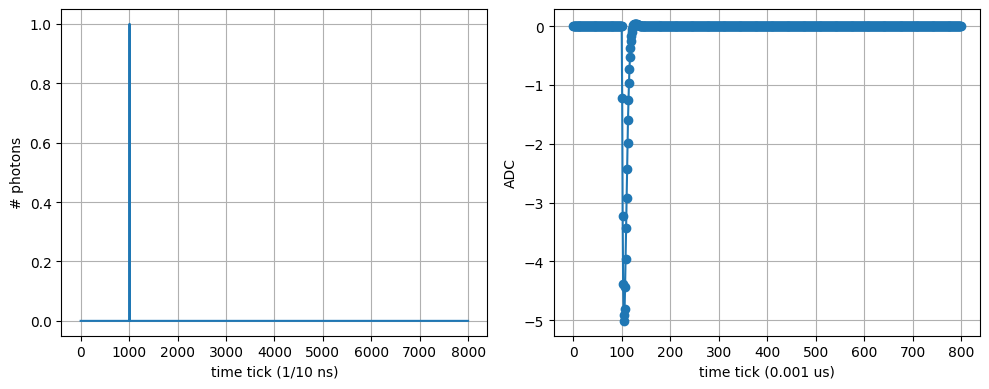

In [3]:
# Generating Waveform
pmt_ids = torch.arange(1)
arrival_times = torch.zeros(1, dtype=torch.int64) + 1000 # units of 1/10 ns
wf = sim.gen_waveform(mode='precise', pmt_ids=pmt_ids, arrival_times=arrival_times, n_pmts=1)

# Electronics Convolution
output, _ = sim(wf.to(device), scintillation=False, tpb_delay=False, combined=False)
output = output.detach().cpu().numpy()

fig, axes = plt.subplots(1, 2, figsize=(10, 4))  # 1 row, 2 columns

# First plot
axes[0].plot(wf[0])
axes[0].set_ylabel("# photons")
axes[0].set_xlabel("time tick (1/10 ns)")
axes[0].grid(True)

# Second plot
axes[1].plot(output, marker='o')
axes[1].grid(True)
axes[1].set_xlabel(f"time tick ({sim.light_tick_size} us)")
axes[1].set_ylabel("ADC")

plt.tight_layout()
plt.show()

### Generating `n` photon samples, every 100  picoseconds within 1 nanosecond

In [115]:
num_waveforms = 100000
nphotons = 5

####################################################

sim_waveforms = []
arrival_times_list = []
numbers = np.arange(4000, 4010) # array([4000, 4001, ..., 4009])
all_arrival_times = np.repeat(numbers, (num_waveforms * nphotons) / numbers.shape[0])
print(all_arrival_times.shape)

for i in range(num_waveforms):
    pmt_ids = torch.full((nphotons,), 0, dtype=torch.int64)  # PMT 0 for all photons
    arrival_times = all_arrival_times[nphotons*i:nphotons*i+nphotons]
    arrival_times_tensor = torch.tensor(arrival_times)
    arrival_times_list.append(arrival_times_tensor / sim.downsample_factor)
    wf = sim.gen_waveform(mode='precise', pmt_ids=pmt_ids, arrival_times=arrival_times_tensor, n_pmts=1)
    output, info = sim(wf.to(device), scintillation=False, tpb_delay=False, combined=False)
    output = output.detach().cpu().numpy()
    
    # adding some noise AFTER generating the waveform
    noise = torch.normal(mean=0.0, std=(0.2 * 1.65), size=output.shape)
    signal = output + noise.numpy()
    ##################################################

    sim_waveforms.append(signal) # instead of output

data = {}
data['waveforms'] = sim_waveforms
data['arrival_times'] = arrival_times_list

np.save("5photon_study.npy", data, allow_pickle=True)

(500000,)


### Inspecting Generated Data

Text(0.5, 1.0, 'Input 1D Waveform with 5-photon Signal')

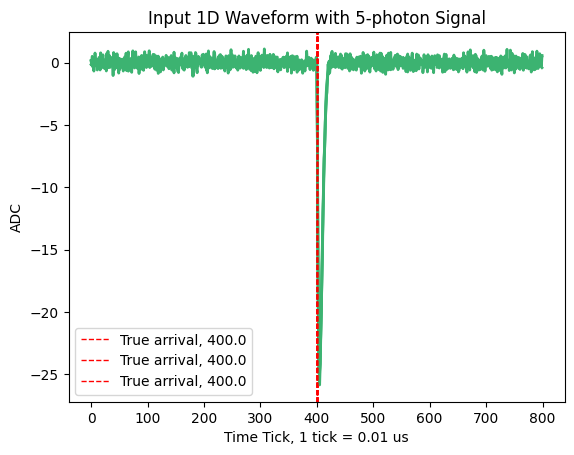

In [116]:
waveforms = np.load('5photon_study.npy', allow_pickle=True).item()
ticks = np.arange(len(waveforms['waveforms'][0]))

for i, wf in enumerate(waveforms['waveforms'][:3]):
    plt.plot(ticks, wf, linewidth=2, color='mediumseagreen')
    for j, t in enumerate(waveforms['arrival_times'][i]):
        # print(waveforms['arrival_times'][i])
        plt.axvline(
            x=t.item(), 
            color='r', 
            linestyle='--', 
            linewidth=1, 
            label=f'True arrival, {t.item():.1f}' if j == 0 else ""
        )

plt.xlabel(f"Time Tick, 1 tick = {sim.light_tick_size * sim.downsample_factor} us")
plt.ylabel("ADC")
plt.legend()
plt.title(f"Input 1D Waveform with {nphotons}-photon Signal")

In [117]:
print(np.unique(waveforms['arrival_times']))


[400.  400.1 400.2 400.3 400.4 400.5 400.6 400.7 400.8 400.9]


### Generating a Training Sample for SINGLE Hit per Window
**Parameters**
- `window_size` = 800 ns (easy to downsample / upsample cleanly in UNet)

**Data Qualities**
- Random arrival times between 50 and 750 ns with resolution at 100-picosecond level
- Random photons per signal between 1 and 10

In [86]:
num_waveforms = 100000
offset = 0

nphotons = np.random.randint(1, 2, num_waveforms)  # random integers between 1 and 1000
all_arrival_times = np.random.randint(50, 7501, size=num_waveforms)
sim_waveforms = []

for i, n in enumerate(nphotons):
    pmt_ids = torch.full((n,), 0, dtype=torch.int64)  # PMT 0 for all photons
    arrival_time = int(all_arrival_times[i])  # convert to int for torch.full
    arrival_times_tensor = torch.full((n,), arrival_time, dtype=torch.int64)

    wf = sim.gen_waveform(mode='precise', pmt_ids=pmt_ids, arrival_times=arrival_times_tensor, n_pmts=1)
    output, info = sim(wf.to(device), scintillation=False, tpb_delay=False, combined=False)
    output = output.detach().cpu().numpy()

    # adding some noise AFTER generating the waveform
    noise = torch.normal(mean=0.0, std=(0.2 * 4.8), size=output.shape)
    signal = output + noise.numpy()
    #################################################
    
    sim_waveforms.append(signal) # instead of output

data = {}
data['waveforms'] = sim_waveforms
data['arrival_times'] = (all_arrival_times / sim.downsample_factor) #+ (offset / sim.downsample_factor)

np.save("testtest.npy", data, allow_pickle=True)

650.4
420.5
549.0
614.5
315.9
411.2
174.2


Text(0.5, 1.0, 'Input 1D Waveforms')

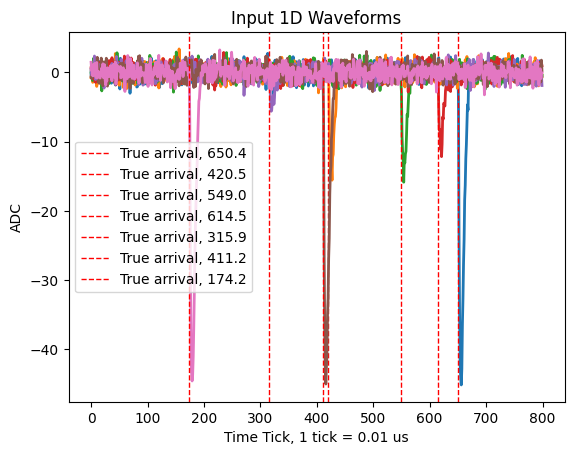

In [87]:
waveforms = np.load('test_random.npy', allow_pickle=True).item()
ticks = np.arange(len(waveforms['waveforms'][0]))

for i, wf in enumerate(waveforms['waveforms'][:7]):
    plt.plot(ticks, wf, linewidth=2)
    # for j, t in enumerate(waveforms['arrival_times'][i]):
    t = waveforms['arrival_times'][i]
    print(t)
    plt.axvline(
        x=t.item(), 
        color='r', 
        linestyle='--', 
        linewidth=1, 
        label=f'True arrival, {t.item():.1f}'
    )

plt.xlabel(f"Time Tick, 1 tick = {sim.light_tick_size * sim.downsample_factor} us")
plt.ylabel("ADC")
plt.legend()
plt.title(f"Input 1D Waveforms")